## Recreating Analysis of Piao Nature 2008

### Step 4: temperature averages for the northern latitudes

- Read in temperature data. File: /Users/moyanofe/BigData/GeoSpatial/Climate/CRU-TS_4.05_1901-2020/cru_ts4.05.1901.2020.tmn.dat.nc
- Calculate averages for:
    - above 30ºN and above 50ºN
    - yearly and seasonally

Note: check for useful code in trend calculations scripts

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
# File with global land surface temperature data
file = '/Users/moyanofe/BigData/GeoSpatial/Climate/CRU-TS_4.05_1901-2020/cru_ts4.05.1901.2020.tmp.dat.nc'

# Latitude limites for calculating temperature averages
limS = 30
limN = 80

In [3]:
# Load the data
ds_t = xr.open_dataset(file)
da_t = ds_t['tmp']
da_tr = da_t.sel(lat=slice(limS,limN)) # Get values only for the region of interest
# To exclude Greenland, this should be approximate
da_tr = da_tr.where((da_tr.lon > -20) | (da_tr.lon < -60) | (da_tr.lat < 60)) 

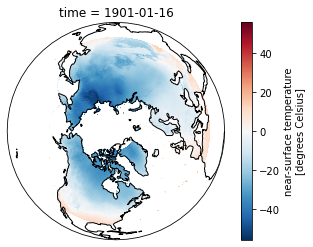

In [4]:
from map_xarray import map_xarray
map_xarray(da_t.sel(lat=slice(limS,limN)))

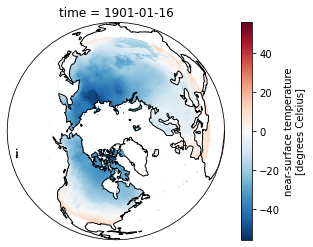

In [5]:
from map_xarray import map_xarray
map_xarray(da_tr)

In [ ]:
# Get yearly averages for the region
# See https://docs.xarray.dev/en/stable/examples/area_weighted_temperature.html

# First average in time
da_try = da_tr.groupby('time.year').mean() # try = temperature, region, yearly
# Then average for the region (weight by gridcell size)
weights = np.cos(np.deg2rad(da_try.lat)) # cosine of latitude is a proxy of gridcell size
weights.name = "weights" # Not sure why this is required 
da_tryw = da_try.weighted(weights) # Get weighted values
da_trym = da_tryw.mean(('lat', 'lon')) # Get the average over lat and lon

In [ ]:
# Get seasonal averages
# See: https://docs.xarray.dev/en/stable/examples/monthly-means.html

# To be precise, need to weight by the actual month lengths

# First create a year_season coordinate used to group the data
year_np = da_tr['time.year'].to_pandas()
season_np = da_tr['time.season'].to_pandas()
year_season_idx = pd.MultiIndex.from_arrays([year_np, season_np])
da_tr.coords['year_season'] = ('time', year_season_idx)

# Create a data array with number of days per month
month_length = da_tr.time.dt.days_in_month

# Calculate the weights for each month by grouping by 'year_season'.
weights =  month_length.groupby("year_season") / month_length.groupby("year_season").sum()

# Test that the sum of the weights for each season is 1.0. (No output or None is good)
np.testing.assert_allclose(weights.groupby("year_season").sum().values, np.ones(480))

# Calculate the weighted average for each season and year (i.e. the sum of the weighted values)
da_trs = (da_tr * weights).groupby("year_season").sum(dim="time")

# Get the average for the entire region (weight by gridcell size) ----

# Get the sum of the relative areas for cells with temp data
da_ones = da_tr.isel(time=0) / da_tr.isel(time=0)
glob_w = da_ones * np.cos(np.deg2rad(da_trs.lat))
glob_ws = glob_w.sum()

# Then weight and divide by total weighting sum
weights = np.cos(np.deg2rad(da_trs.lat))
weights.name = "weights"
da_trsw = da_trs.weighted(weights) # Get weighted values
da_trsm = da_trsw.sum(('lat', 'lon')) / glob_ws.values # Get the average over lat and lon

In [ ]:
# Convert to pandas df

# First get the year-season coordinate and convert to a pandas MultiIndex
ys = da_trsm['year_season'].to_pandas()
index = pd.MultiIndex.from_tuples(ys)
# Second convert arraydata and MultiIndex to dataframe (the latter maybe unnecessary)
df1 = da_trsm.to_dataframe(name='tmp')
df2 = index.to_frame()
# Third concat the dfs and add the index
ts = pd.concat([df1, df2], axis=1)
ts = ts.set_index(index)
ts.columns = ['tmp', 'year', 'season']

# Add to the yearly dataframe
tm = da_trym.to_dataframe(name='tmp_year')

for s in ['DJF', 'MAM', 'JJA', 'SON']:
    name = 'tmp_' + s
    data = ts.loc[ts['season']==s, 'tmp']
    data = data.reset_index(level=1, drop=True)
    tm[name] = data

file_out = 'tmp_yearly_means_' + str(limS) + str(limN) + 'N.csv'
tm.to_csv('../data/piao_2008/' + file_out)
